# Scenario 1: User-User Collaborative Filtering

This notebook implements a **User-User Collaborative Filtering** recommendation system. 

## Concept
User-User Collaborative Filtering works on the principle that users who have agreed in the past will agree in the future. It finds users who have similar rating patterns and recommends items that those similar users liked but the target user hasn't seen yet.

### Key Steps:
1. **User Item Matrix**: Represent users and movies in a matrix where cells contain ratings.
2. **Similarity Computation**: Calculate similarity between users (e.g., using Cosine Similarity).
3. **Neighbor Selection**: Identify top $K$ users most similar to the target user.
4. **Rating Prediction**: Estimate ratings for movies not yet seen by the target user based on neighbors' ratings.
5. **Recommendation**: Suggest the highest-rated movies.

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')

print(f"Loaded {len(movies)} movies and {len(ratings)} ratings.")

Loaded 9742 movies and 100836 ratings.


## 1. Data Preparation
We need to transform the long-format ratings data into a wide-format **User-Item Matrix**.

In [3]:
# Create user item matrix
# index: userId, columns: movieId, values: rating
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Fill NaN with 0 (unrated movies)
user_item_matrix_filled = user_item_matrix.fillna(0)

print(f"User Item Matrix Shape: {user_item_matrix_filled.shape}")
user_item_matrix_filled.head()

User Item Matrix Shape: (610, 9724)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Similarity Computation
We use **Cosine Similarity** to measure how similar two users are based on their rating vectors.

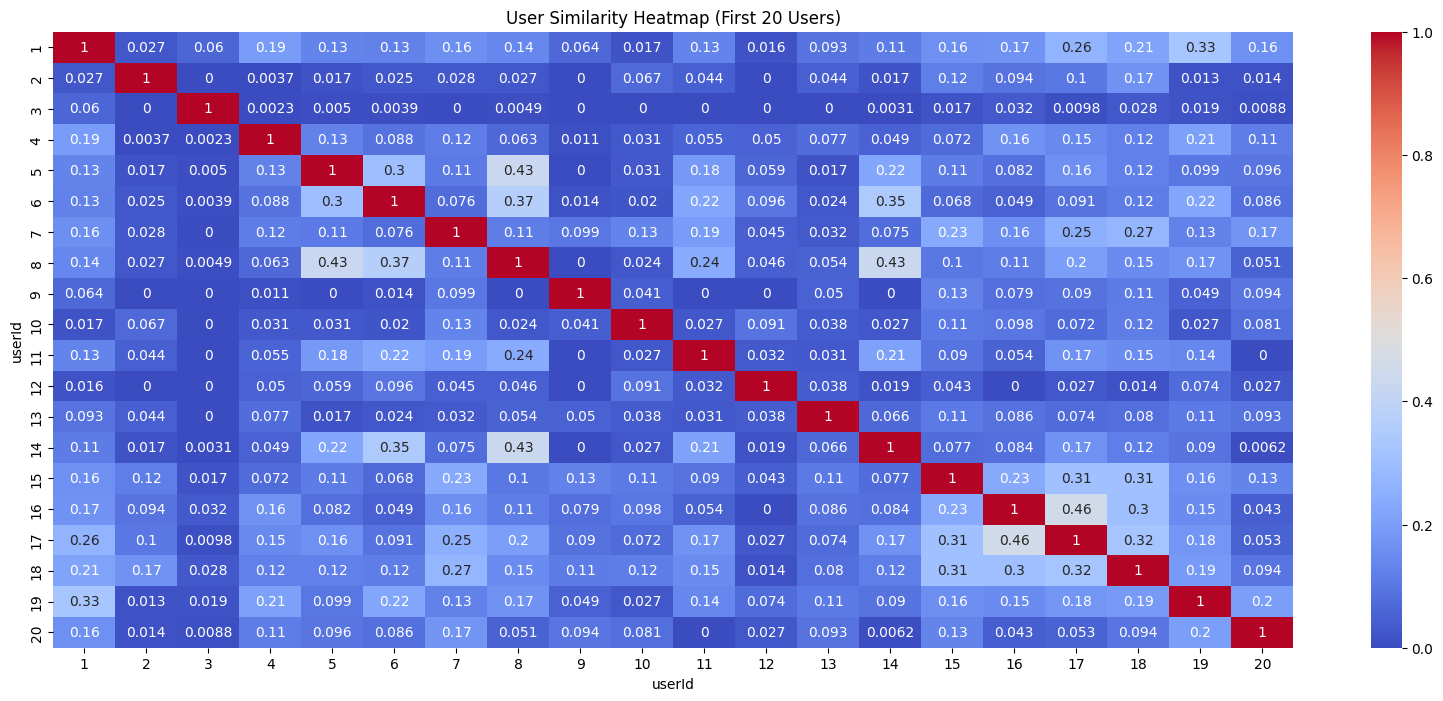

In [5]:
# Compute cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix_filled)

# Convert to DataFrame for easier manipulation
user_similarity_df = pd.DataFrame(
    user_similarity, 
    index=user_item_matrix_filled.index, 
    columns=user_item_matrix_filled.index
)

# Visualize a small portion of the similarity matrix
plt.figure(figsize=(20, 8))
sns.heatmap(user_similarity_df.iloc[:20, :20], annot=True, cmap='coolwarm')
plt.title('User Similarity Heatmap (First 20 Users)')
plt.show()

## 3. Recommendation Engine
The function below implements the logic to find neighbors and predict ratings.

In [6]:
def get_user_recommendations(user_id, n_neighbors=10, n_recommendations=5):
    """
    Predicts movie recommendations for a specific user using User-User CF.
    """
    # 1. Find the most similar users (neighbors)
    # Exclude the user themselves (similarity 1.0 at the diagonal)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index[1:n_neighbors+1]

    # 2. Get ratings from these similar users
    neighbor_ratings = user_item_matrix_filled.loc[similar_users]

   
    # 3. Calculate weighted average of ratings
    # weights are the similarity scores
    weights = user_similarity_df.loc[user_id, similar_users]
    
    # Matrix multiplication: (1, n_neighbors) * (n_neighbors, n_movies) -> (1, n_movies)
    weighted_sum = np.dot(weights, neighbor_ratings)
    sum_of_weights = np.sum(weights)
    
    if sum_of_weights == 0:
        return "No recommendations possible for this user."
    
    prediction_scores = weighted_sum / sum_of_weights
    
    # 4. Filter out movies the user has already seen
    user_seen_movies = user_item_matrix.loc[user_id].dropna().index
    
    # Create a series with movieIds as index
    recommendation_series = pd.Series(prediction_scores, index=user_item_matrix_filled.columns)
    recommendation_series = recommendation_series.drop(user_seen_movies, errors='ignore')
    
    # 5. Get Top N recommendations
    top_movie_ids = recommendation_series.sort_values(ascending=False).head(n_recommendations).index
    
    # Join with movie titles
    recommended_movies = movies[movies['movieId'].isin(top_movie_ids)].copy()
    recommended_movies['predicted_score'] = recommended_movies['movieId'].map(recommendation_series)
    
    return recommended_movies.sort_values('predicted_score', ascending=False)

In [7]:
# Example:
target_user = 7
recommendations = get_user_recommendations(target_user)
print(f"Top 5 Recommendations for User {target_user}:")
recommendations

Top 5 Recommendations for User 7:


,movieId,title,genres,predicted_score
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.225779
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.188422
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.113353
1503,2028,Saving Private Ryan (1998),Action|Drama|War,3.884042
3854,5418,"Bourne Identity, The (2002)",Action|Mystery|Thriller,3.877996


## 4. Evaluation & Insights


In [8]:
user_history = ratings[ratings['userId'] == target_user].merge(movies, on='movieId')
print(f"User {target_user}'s Top Rated Movies:")
user_history.sort_values('rating', ascending=False).head(10)

User 7's Top Rated Movies:


,userId,movieId,rating,timestamp,title,genres
40,7,2019,5.0,1106713565,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama
8,7,466,5.0,1106635532,Hot Shots! Part Deux (1993),Action|Comedy|War
26,7,1219,5.0,1106635496,Psycho (1960),Crime|Horror
28,7,1240,5.0,1106712575,"Terminator, The (1984)",Action|Sci-Fi|Thriller
14,7,593,5.0,1106635912,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
59,7,3869,5.0,1106635733,"Naked Gun 2 1/2: The Smell of Fear, The (1991)",Comedy
30,7,1270,5.0,1106635681,Back to the Future (1985),Adventure|Comedy|Sci-Fi
9,7,480,5.0,1106635917,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
32,7,1584,5.0,1106635423,Contact (1997),Drama|Sci-Fi
6,7,356,5.0,1106635915,Forrest Gump (1994),Comedy|Drama|Romance|War
